In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import pickle
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from modules import *

plt.rcParams['font.size'] = 13
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.family'] = 'Arial'

## Load data

In [2]:
# directory
dir_load = 'data/data_processed'
subj_list = [
    'w965a4a3',
    'w2cf6dda',
    'wf010b3e',
    'wd4f37ac',
    'w6b9d6f5',
    'w13af226',
    'wa193ebb',
    'w41fd54e',
    'wf8ea6d2',
    'w932e053',
    'w94abfc5',
    'wb66bb8e',
    'w2745be0',
    'we284b29',
    'wfca9e9d',
    'w65882b1',
    'wd7a2628',
    'w9c2d004',
    'w5718ddc',
    'w9564981',
    'wf4e5037',
    'w8114143',
    'w366d84d',
    'wb680bbe',
    'wb666b62',
    'w372a061',
    'wec7fe05',
    'we6fc6a7',
    'wc6007d5',
    'w66a0c83',
    'w3e17086',
    'w9f25b4d',
    'w96d6a12',
    'w57507c5',
    'w423e302',
    'w3dea2c5',
    'wc35aa68',
    'wc807245',
    'w21ecefc',
    'wb94879d',
    'w84845cc',
    'wfd9b752',
    'wd361f5e',
    'w034037a',
    'w6155833',
    'w802176b',
    'w581d495',
    'w0cafb94',
    'w9349321',
    'w943b3ab',
]

num_subj = len(subj_list)
num_trial = 100

In [3]:
data = []

# loop through subjects
for subj_id in subj_list:

    # load data
    data_subj = pickle.load(open(f'{dir_load}/{subj_id}.p', 'rb'))
    data.append(data_subj)

data_subj.keys()

dict_keys(['graphs', 'rewards', 'starts', 'time_limits', 'hover_seqs', 'visit_seqs', 'hover_time_seqs', 'visit_time_seqs', 'max_depths', 'child_dicts', 'hover_counts', 'rollout_counts', 'cum_rewards', 'action_values', 'hover_times', 'visit_times'])

In [4]:
hover_times = []
visit_times = []
rollout_counts = []

for i in range(num_subj):
    data_subj = data[i]

    hover_times += data_subj['hover_times']
    visit_times += data_subj['visit_times']
    rollout_counts += data_subj['rollout_counts']

hover_times = np.array(hover_times)
visit_times = np.array(visit_times)
rollout_counts = np.array(rollout_counts)

indices = np.where((hover_times != None) & (visit_times != None))[0]

time_cost_ratio = (hover_times[indices].mean() / rollout_counts[indices].mean()) / visit_times[indices].mean()

In [5]:
dfs = []

for i in range(num_subj):
    data_subj = data[i]

    # depth-1 rewards
    depth_1_rewards_subj = []
    max_depth_1_rewards_subj = []
    min_depth_1_rewards_subj = []
    max_depth_1_reward_indices_subj = []

    # action values
    action_values_subj = []
    max_action_values_subj = []
    min_action_values_subj = []
    max_action_value_indices_subj = []

    # chosens
    chosen_indices_subj = []
    chosen_action_values_subj = []
    accuracies_subj = []

    # loop throught trials
    for k in range(num_trial):
        # depth-1 rewards
        depth_1_nodes = data_subj['child_dicts'][k][data_subj['starts'][k]]
        depth_1_rewards = [data_subj['rewards'][k][_] for _ in depth_1_nodes]
        max_depth_1_reward = np.max(depth_1_rewards)
        min_depth_1_reward = np.min(depth_1_rewards)
        max_depth_1_reward_index = np.argmax(depth_1_rewards)

        # action values
        action_values = data_subj['action_values'][k]
        max_action_value = np.max(action_values)
        min_action_value = np.min(action_values)
        max_action_value_index = np.argmax(action_values)

        # chosens
        chosen_node = data_subj['visit_seqs'][k][1]
        chosen_index = depth_1_nodes.index(chosen_node)
        chosen_action_value = data_subj['action_values'][k][chosen_index]
        accuracy = int(chosen_action_value == max_action_value)

        # append
        depth_1_rewards_subj.append(depth_1_rewards)
        max_depth_1_rewards_subj.append(max_depth_1_reward)
        min_depth_1_rewards_subj.append(min_depth_1_reward)
        max_depth_1_reward_indices_subj.append(max_depth_1_reward_index)
        action_values_subj.append(action_values)
        max_action_values_subj.append(max_action_value)
        min_action_values_subj.append(min_action_value)
        max_action_value_indices_subj.append(max_action_value_index)
        chosen_indices_subj.append(chosen_index)
        chosen_action_values_subj.append(chosen_action_value)
        accuracies_subj.append(accuracy)

    # df
    df_subj = pd.DataFrame({
        'subj_id': i,
        'hover_counts': data_subj['hover_counts'],
        'rollout_counts': data_subj['rollout_counts'],
        'max_depths': data_subj['max_depths'],
        'time_limits': data_subj['time_limits'],
        'depth_1_rewards': depth_1_rewards_subj,
        'max_depth_1_rewards': max_depth_1_rewards_subj,
        'min_depth_1_rewards': min_depth_1_rewards_subj,
        'max_depth_1_reward_indices': max_depth_1_reward_indices_subj,
        'action_values': action_values_subj,
        'max_action_values': max_action_values_subj,
        'min_action_values': min_action_values_subj,
        'max_action_value_indices': max_action_value_indices_subj,
        'chosen_indices': chosen_indices_subj,
        'chosen_action_values': chosen_action_values_subj,
        'accuracies': accuracies_subj,
    })
    dfs.append(df_subj)

df = pd.concat(dfs, ignore_index = True)
df['scores'] = df['accuracies'] * 2 - 1 # add scores
df.head(10)

,subj_id,hover_counts,rollout_counts,max_depths,time_limits,depth_1_rewards,max_depth_1_rewards,min_depth_1_rewards,max_depth_1_reward_indices,action_values,max_action_values,min_action_values,max_action_value_indices,chosen_indices,chosen_action_values,accuracies,scores
0,0,1,1,1,2.361797,"[4, -8]",4,-8,0,"[4, -8]",4.000,-8.000,0,1,-8.000,0,-1
1,0,4,1,3,13.049031,"[-8, 6]",6,-8,1,"[-2.75, 8.5]",8.500,-2.750,1,1,8.500,1,1
2,0,1,1,3,2.752499,"[-3, -1]",-1,-3,1,"[-1.5, -1.75]",-1.500,-1.750,0,1,-1.750,0,-1
3,0,0,0,4,0.617520,"[-8, -5]",-5,-8,1,"[-4.625, -12.75]",-4.625,-12.750,0,1,-12.750,0,-1
4,0,1,1,4,2.345290,"[8, 7]",8,7,0,"[5.0, 9.875]",9.875,5.000,1,0,5.000,0,-1
5,0,0,0,3,1.629228,"[-1, -5]",-1,-5,0,"[-3.5, -0.75]",-0.750,-3.500,1,1,-0.750,1,1
6,0,0,0,1,0.022777,"[-6, -8]",-6,-8,0,"[-6, -8]",-6.000,-8.000,0,0,-6.000,1,1
7,0,3,1,4,4.260554,"[-1, 6]",6,-1,1,"[-6.125, 9.875]",9.875,-6.125,1,1,9.875,1,1
8,0,0,0,2,1.678786,"[3, 5]",5,3,1,"[-1.0, 6.5]",6.500,-1.000,1,0,-1.000,0,-1
9,0,6,2,3,15.333548,"[-2, -1]",-1,-2,1,"[0.25, -1.5]",0.250,-1.500,0,0,0.250,1,1


In [6]:
mean_accuracies = df.groupby('subj_id')['accuracies'].mean()
valid_subj = mean_accuracies[mean_accuracies >= 0.50].index
df = df[df['subj_id'].isin(valid_subj)]

print(df['subj_id'].unique().shape)

(47,)


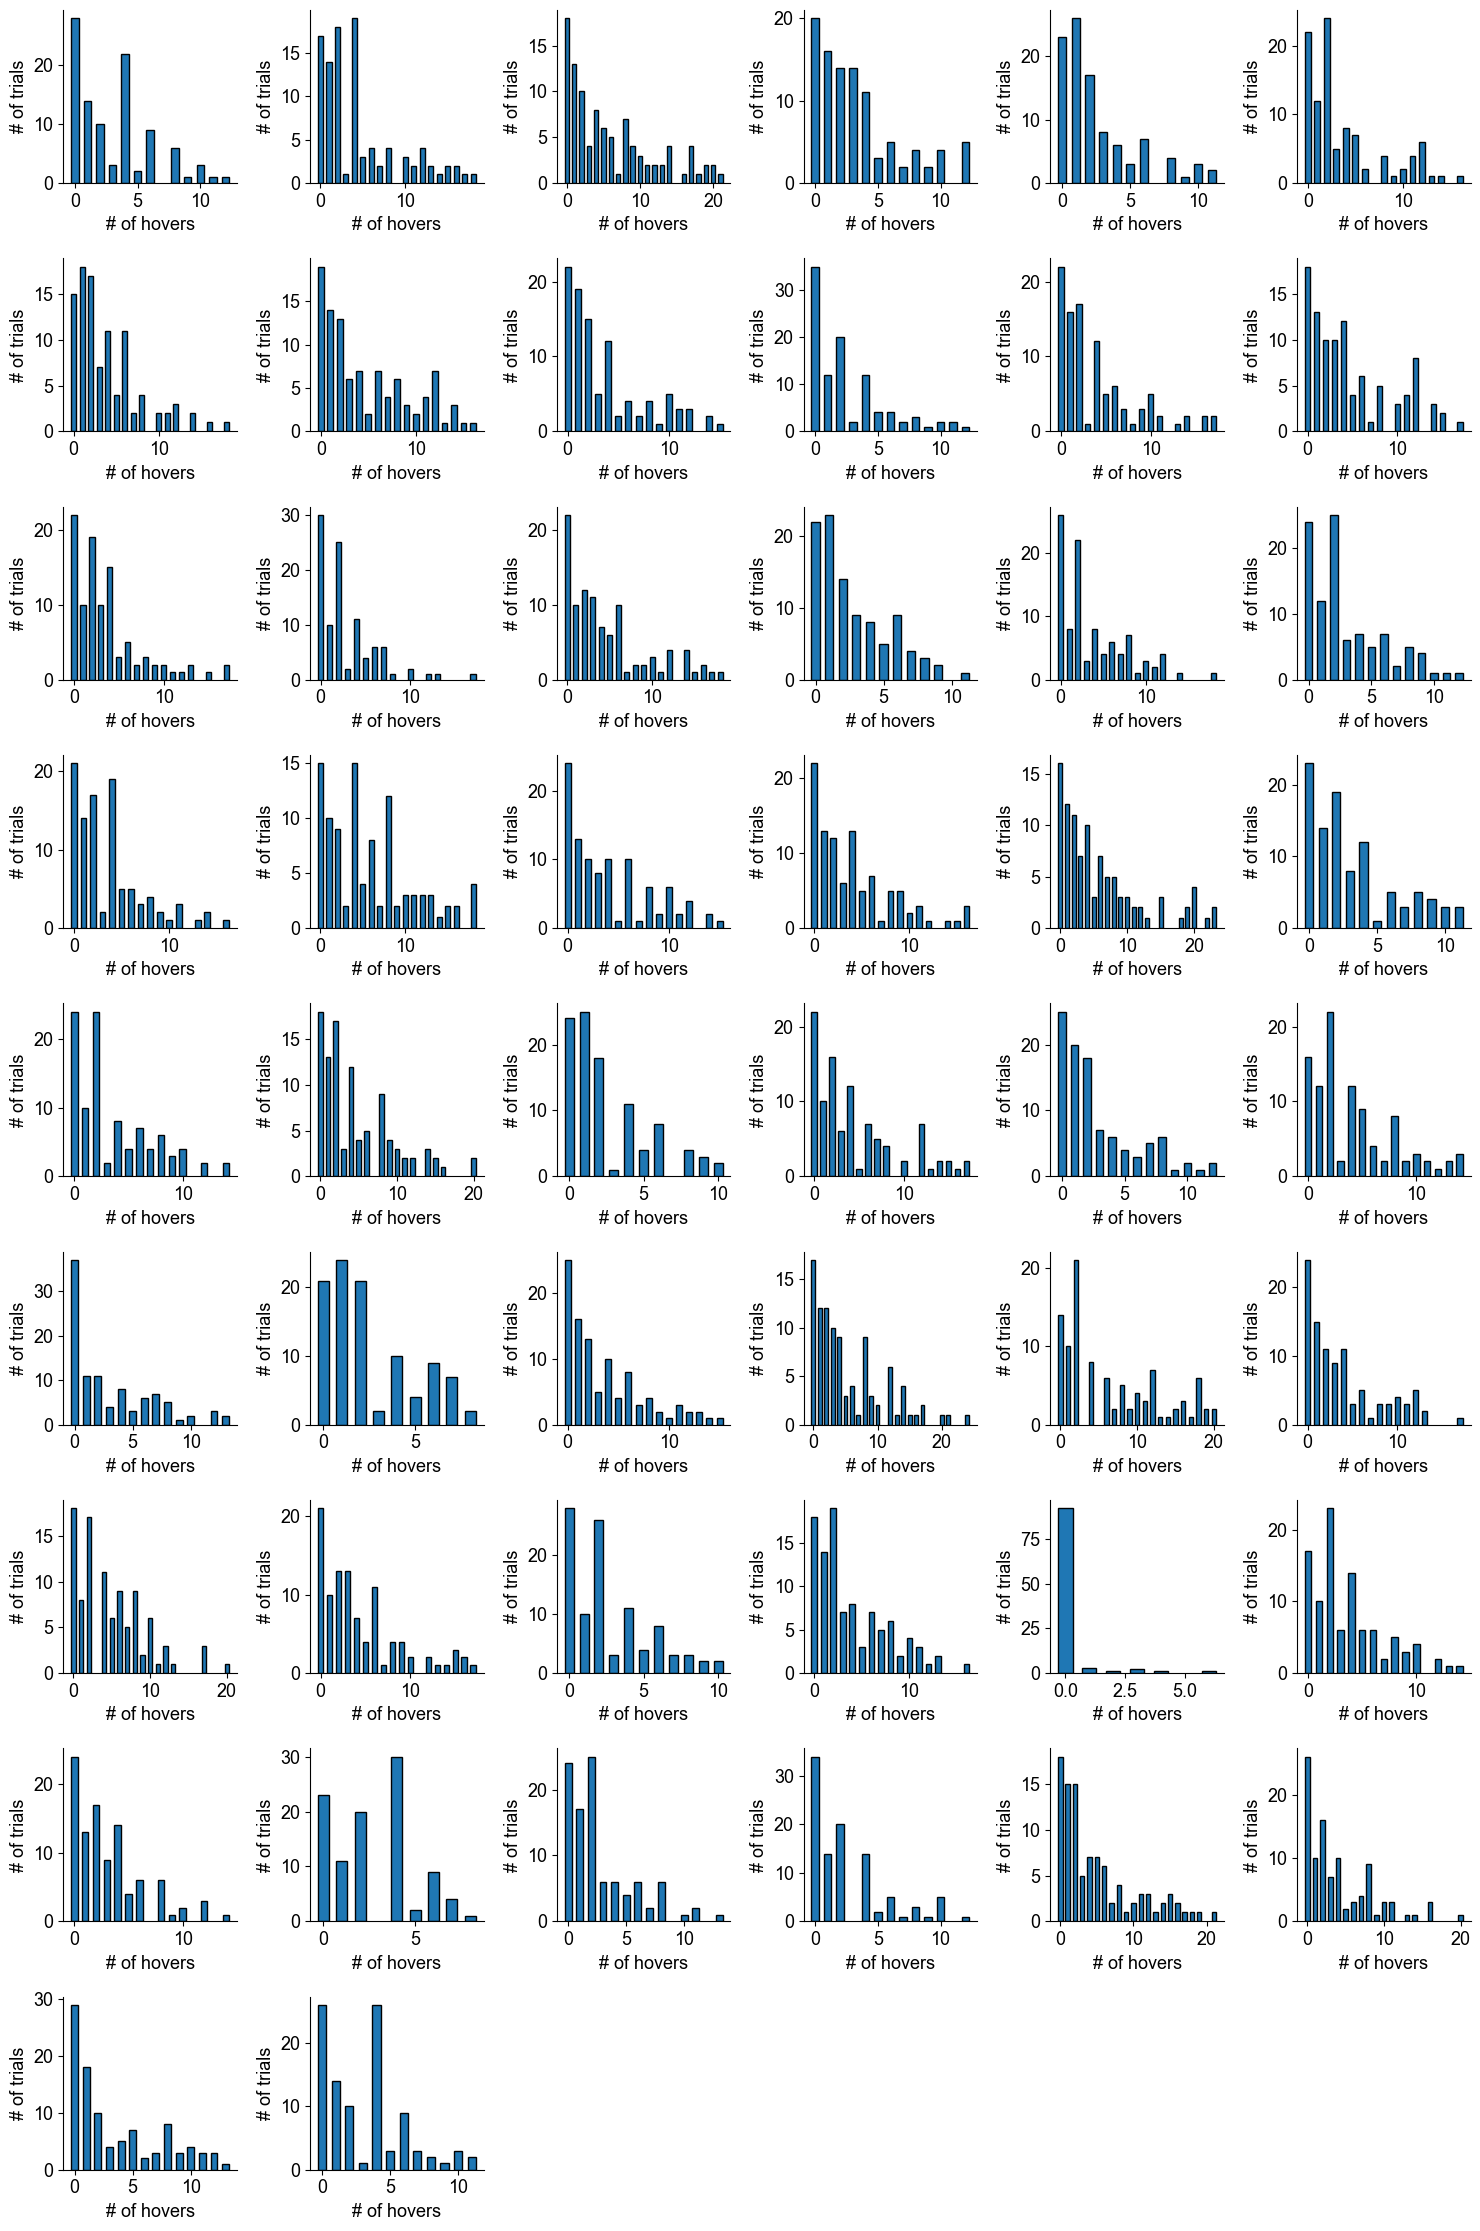

In [7]:
subj_per_row = 6

plt.figure(figsize = (2.5 * subj_per_row, 2.5 * (num_subj // subj_per_row + 1)))

for i in range(num_subj):
    data_subj = data[i]
    counter = dict(Counter(data_subj['hover_counts']))
    plt.subplot(num_subj // subj_per_row + 1, subj_per_row, i + 1)
    plt.bar(counter.keys(), counter.values(), width = 0.6, edgecolor = 'black', align = 'center')
    plt.xlabel('# of hovers')
    plt.ylabel('# of trials')
plt.tight_layout()
plt.show()

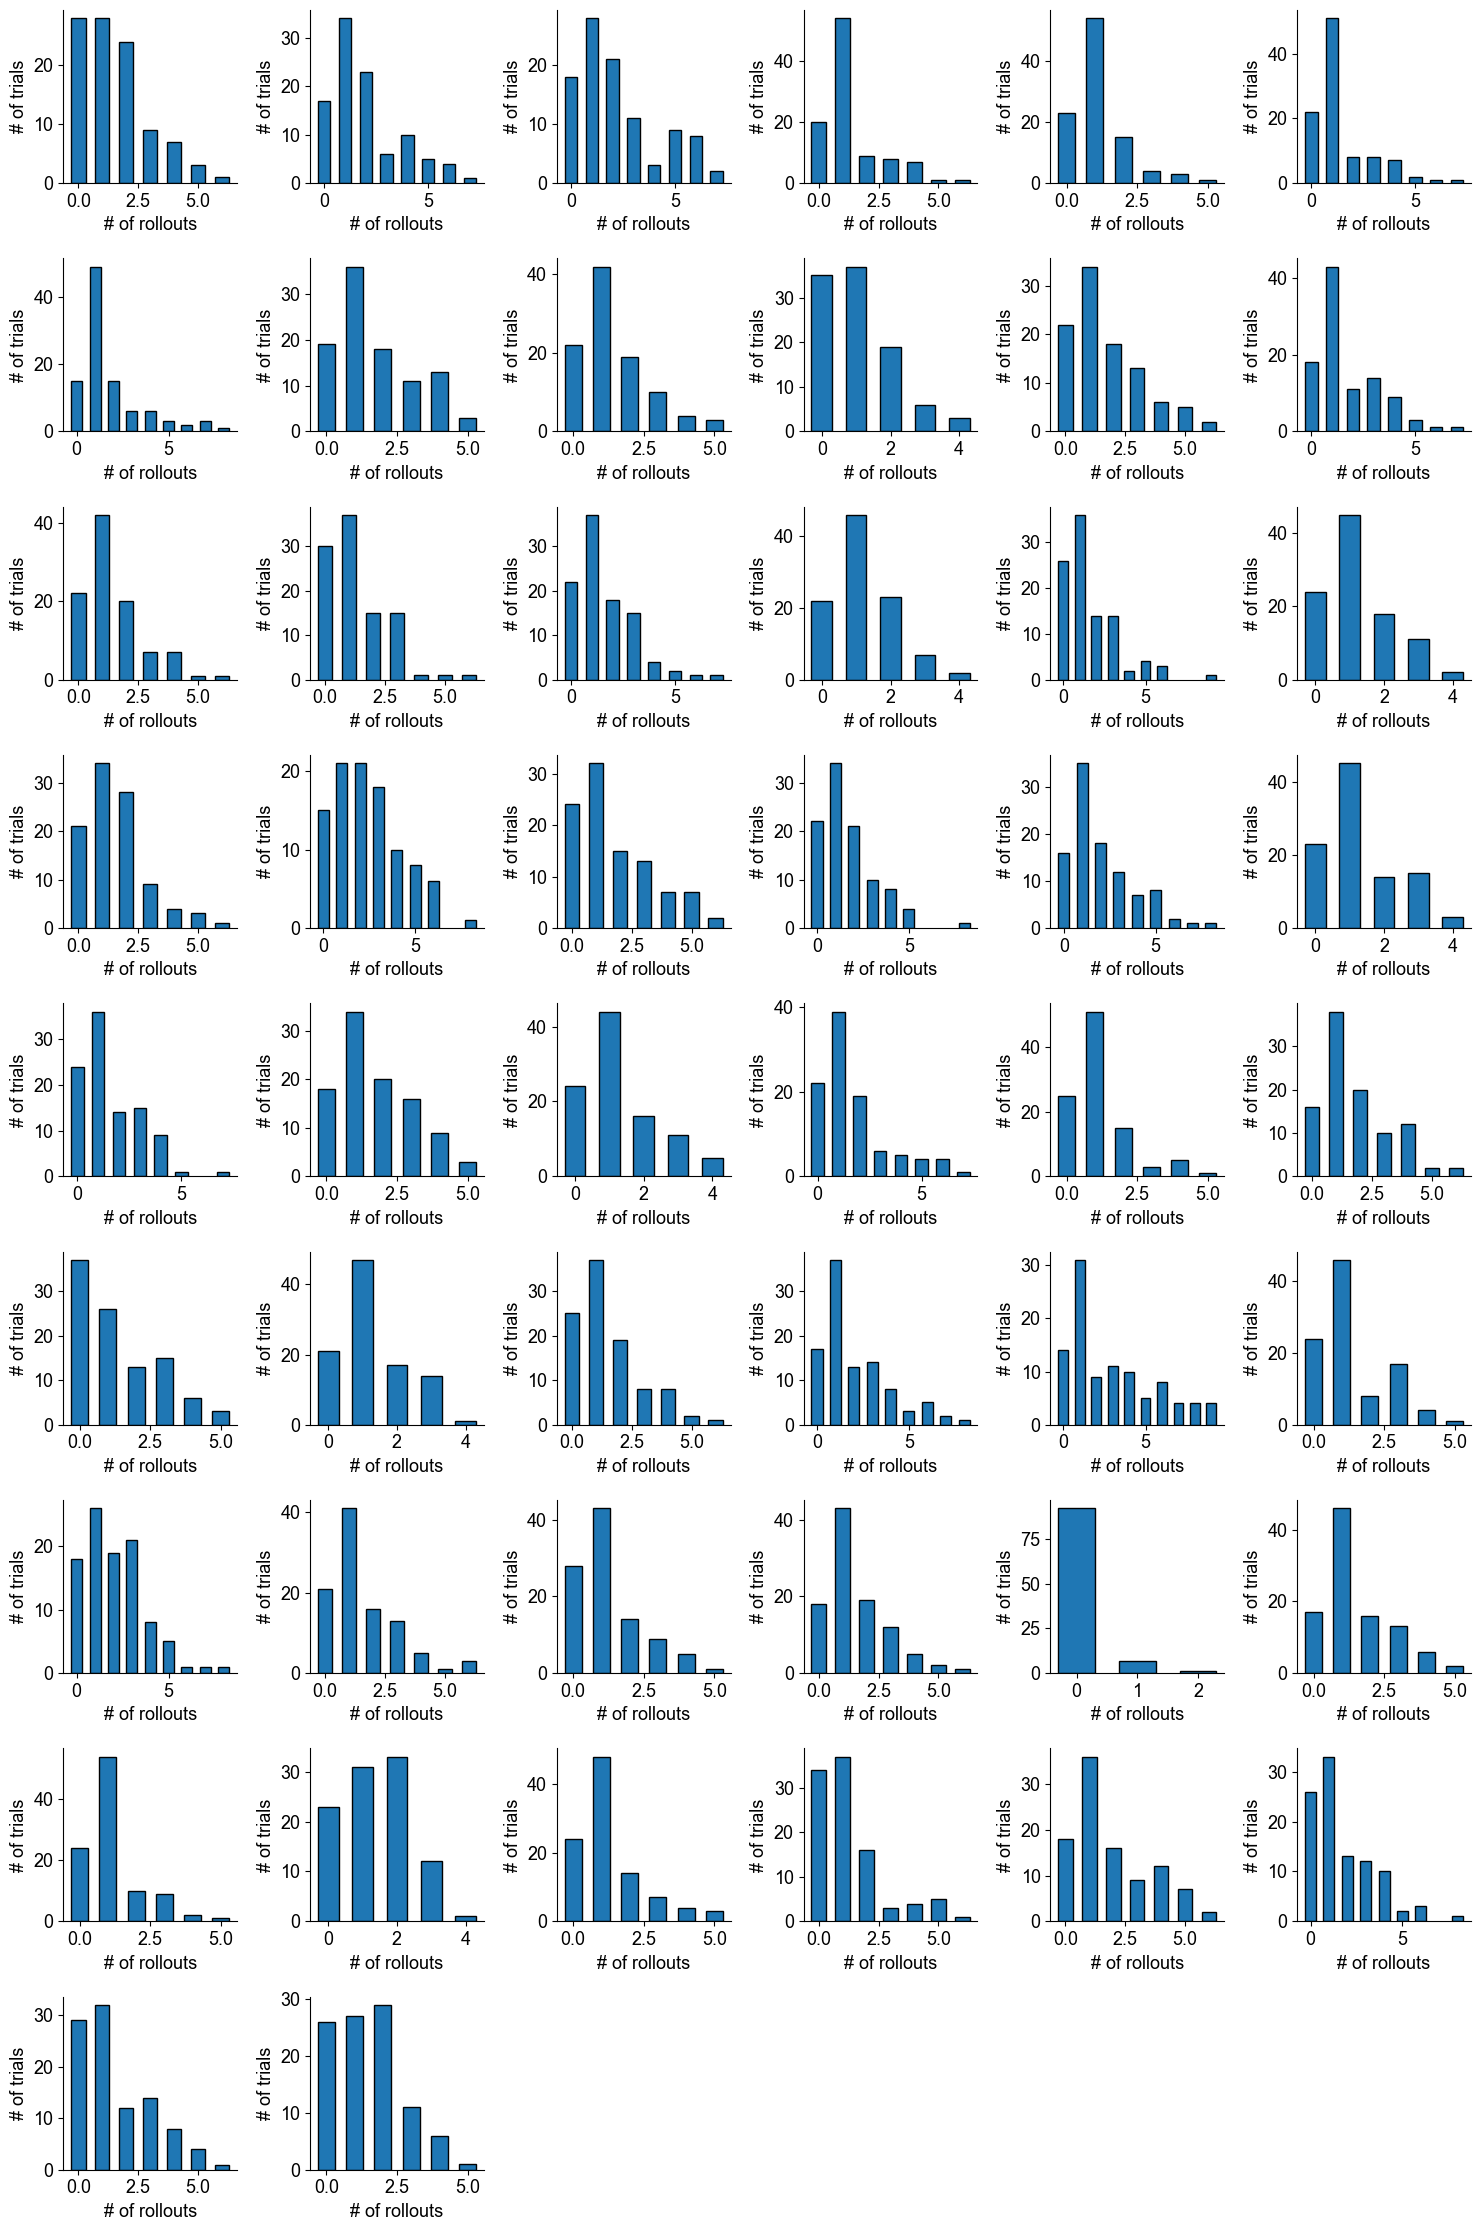

In [8]:
subj_per_row = 6

plt.figure(figsize = (2.5 * subj_per_row, 2.5 * (num_subj // subj_per_row + 1)))

for i in range(num_subj):
    data_subj = data[i]
    counter = dict(Counter(data_subj['rollout_counts']))
    plt.subplot(num_subj // subj_per_row + 1, subj_per_row, i + 1)
    plt.bar(counter.keys(), counter.values(), width = 0.6, edgecolor = 'black', align = 'center')
    plt.xlabel('# of rollouts')
    plt.ylabel('# of trials')
plt.tight_layout()
plt.show()

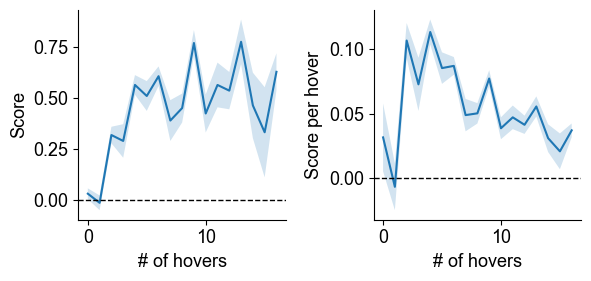

In [9]:
plt.figure(figsize = (6, 3))

for i in range(2):
    df_filtered = df.copy()
    df_filtered['hover_counts'] = df_filtered['hover_counts'].clip(lower = 0, upper = 16)
    df_grouped = df_filtered.groupby(['subj_id', 'hover_counts'])['scores'].mean().reset_index()
    df_grouped = df_grouped.groupby(['hover_counts'])['scores'].agg(['mean', 'sem']).reset_index()

    if i == 1:
        df_grouped['mean'] /= (np.array(df_grouped['hover_counts']) + 1)
        df_grouped['sem'] /= (np.array(df_grouped['hover_counts']) + 1)
        
    plt.subplot(1, 2, i + 1)
    plt.plot(df_grouped['hover_counts'], df_grouped['mean'])
    plt.axhline(y = 0., color = 'k', linestyle = '--', linewidth = 1)
    plt.fill_between(df_grouped['hover_counts'], df_grouped['mean'] - df_grouped['sem'], df_grouped['mean'] + df_grouped['sem'], alpha = 0.2)
    plt.xlabel('# of hovers')

    if i == 0:
        plt.ylabel('Score')
    elif i == 1:
        plt.ylabel('Score per hover')
    
plt.tight_layout()
plt.show()

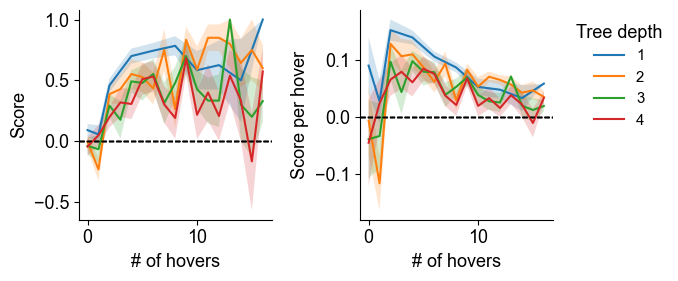

In [10]:
plt.figure(figsize = (7, 3))

for i in range(2):
    df_filtered = df.copy()
    df_filtered['hover_counts'] = df_filtered['hover_counts'].clip(lower = 0, upper = 16)
    df_grouped = df_filtered.groupby(['subj_id', 'hover_counts', 'max_depths'])['scores'].mean().reset_index()
    df_grouped = df_grouped.groupby(['hover_counts', 'max_depths'])['scores'].agg(['mean', 'sem']).reset_index()

    plt.subplot(1, 2, i + 1)

    for max_depth in [1, 2, 3, 4]:
        df_grouped_depth = df_grouped[df_grouped['max_depths'] == max_depth]

        if i == 1:
            df_grouped_depth['mean'] /= (np.array(df_grouped_depth['hover_counts']) + 1)
            df_grouped_depth['sem'] /= (np.array(df_grouped_depth['hover_counts']) + 1)

            # df_grouped_depth['mean'] /= np.where(np.array(df_grouped_depth['hover_counts']) == 0, 1, np.array(df_grouped_depth['hover_counts']))
            # df_grouped_depth['sem'] /= np.where(np.array(df_grouped_depth['hover_counts']) == 0, 1, np.array(df_grouped_depth['hover_counts']))

        plt.plot(df_grouped_depth['hover_counts'], df_grouped_depth['mean'], label = max_depth)
        plt.axhline(y = 0., color = 'k', linestyle = '--', linewidth = 1)
        plt.fill_between(df_grouped_depth['hover_counts'], df_grouped_depth['mean'] - df_grouped_depth['sem'], df_grouped_depth['mean'] + df_grouped_depth['sem'], alpha = 0.2)
        plt.xlabel('# of hovers')

        if i == 0:
            plt.ylabel('Score')
        elif i == 1:
            plt.ylabel('Score per hover')

plt.legend(bbox_to_anchor = (1.05, 1), title = 'Tree depth', loc = 'upper left', frameon = False, fontsize = 'small')
plt.tight_layout()
plt.show()

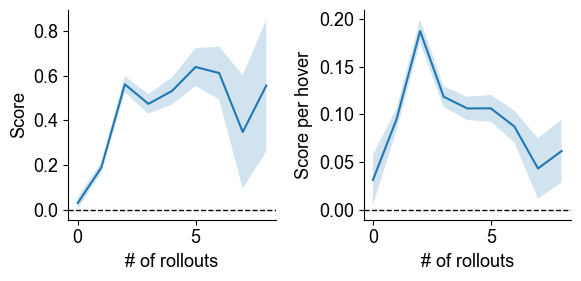

In [11]:
plt.figure(figsize = (6, 3))

for i in range(2):
    df_filtered = df.copy()
    df_filtered['rollout_counts'] = df_filtered['rollout_counts'].clip(lower = 0, upper = 8)
    df_grouped = df_filtered.groupby(['subj_id', 'rollout_counts'])['scores'].mean().reset_index()
    df_grouped = df_grouped.groupby(['rollout_counts'])['scores'].agg(['mean', 'sem']).reset_index()

    if i == 1:
        df_grouped['mean'] /= (1 + np.array(df_grouped['rollout_counts']) * 1)
        df_grouped['sem'] /= (1 + np.array(df_grouped['rollout_counts']) * 1)

    plt.subplot(1, 2, i + 1)
    plt.plot(df_grouped['rollout_counts'], df_grouped['mean'])
    plt.axhline(y = 0., color = 'k', linestyle = '--', linewidth = 1)
    plt.fill_between(df_grouped['rollout_counts'], df_grouped['mean'] - df_grouped['sem'], df_grouped['mean'] + df_grouped['sem'], alpha = 0.2)
    plt.xlabel('# of rollouts')

    if i == 0:
        plt.ylabel('Score')
    elif i == 1:
        plt.ylabel('Score per hover')
    
plt.tight_layout()
plt.show()

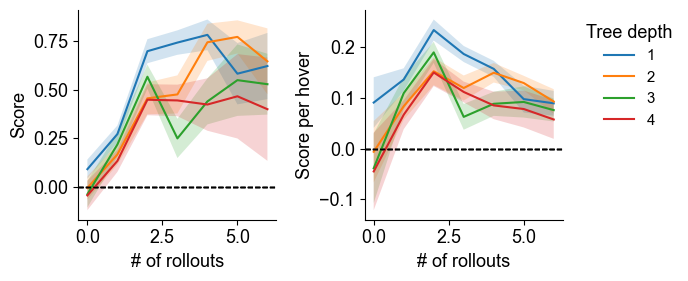

In [12]:
plt.figure(figsize = (7, 3))

for i in range(2):
    df_filtered = df.copy()
    df_filtered['rollout_counts'] = df_filtered['rollout_counts'].clip(lower = 0, upper = 6)
    df_grouped = df_filtered.groupby(['subj_id', 'rollout_counts', 'max_depths'])['scores'].mean().reset_index()
    df_grouped = df_grouped.groupby(['rollout_counts', 'max_depths'])['scores'].agg(['mean', 'sem']).reset_index()

    plt.subplot(1, 2, i + 1)

    for max_depth in [1, 2, 3, 4]:
        df_grouped_depth = df_grouped[df_grouped['max_depths'] == max_depth]

        if i == 1:
            df_grouped_depth['mean'] /= (1 + np.array(df_grouped_depth['rollout_counts']) * 1)
            df_grouped_depth['sem'] /= (1 + np.array(df_grouped_depth['rollout_counts']) * 1)

        plt.plot(df_grouped_depth['rollout_counts'], df_grouped_depth['mean'], label = max_depth)
        plt.axhline(y = 0., color = 'k', linestyle = '--', linewidth = 1)
        plt.fill_between(df_grouped_depth['rollout_counts'], df_grouped_depth['mean'] - df_grouped_depth['sem'], df_grouped_depth['mean'] + df_grouped_depth['sem'], alpha = 0.2)
        plt.xlabel('# of rollouts')

        if i == 0:
            plt.ylabel('Score')
        elif i == 1:
            plt.ylabel('Score per hover')

plt.legend(bbox_to_anchor = (1.05, 1), title = 'Tree depth', loc = 'upper left', frameon = False, fontsize = 'small')
plt.tight_layout()
plt.show()

## With smoothing

In [13]:
def smooth(df, min_value, max_value, bandwidth):
    rollout_counts = df['rollout_counts'].values
    scores = df['scores'].values
    
    # Define range for hover counts
    range = np.linspace(min_value, max_value, max_value - min_value + 1)
    
    smoothed_scores = []
    
    for x in range:
        # Compute Gaussian weights
        weights = np.exp(-0.5 * ((rollout_counts - x) / bandwidth) ** 2)
        weights /= weights.sum()
        
        # Compute weighted average
        smoothed_scores.append(np.sum(weights * scores))
    
    df_smoothed = pd.DataFrame({
        'rollout_counts': range,
        'scores': smoothed_scores
    })

    return df_smoothed

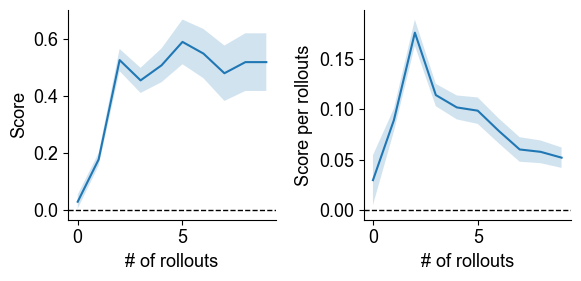

In [14]:
bandwidth = 0.2
min_value = df['rollout_counts'].min()
max_value = df['rollout_counts'].max()

df_smoothed = pd.DataFrame({})

for i in range(num_subj):
    df_subj = df[df['subj_id'] == i]
    df_subj_smoothed = smooth(df_subj, min_value, max_value, bandwidth)

    df_smoothed = pd.concat([df_smoothed, df_subj_smoothed])
    
    
plt.figure(figsize = (6, 3))

for i in range(2):
    df_grouped = df_smoothed.groupby(['rollout_counts'])['scores'].agg(['mean', 'sem']).reset_index()

    if i == 1:
        df_grouped['mean'] /= (np.array(df_grouped['rollout_counts']) + 1)
        df_grouped['sem'] /= (np.array(df_grouped['rollout_counts']) + 1)

    plt.subplot(1, 2, i + 1)
    plt.plot(df_grouped['rollout_counts'], df_grouped['mean'])
    plt.axhline(y = 0., color = 'k', linestyle = '--', linewidth = 1)
    plt.fill_between(df_grouped['rollout_counts'], df_grouped['mean'] - df_grouped['sem'], df_grouped['mean'] + df_grouped['sem'], alpha = 0.2)
    plt.xlabel('# of rollouts')

    if i == 0:
        plt.ylabel('Score')
    elif i == 1:
        plt.ylabel('Score per rollouts')
    
plt.tight_layout()
plt.show()

    rollout_counts  max_depths      mean       sem
0              0.0           1  0.085029  0.046789
4              1.0           1  0.132407  0.022054
8              2.0           1  0.232309  0.021757
12             3.0           1  0.181237  0.016610
16             4.0           1  0.149667  0.014565
20             5.0           1  0.104693  0.017049
24             6.0           1  0.087262  0.015532
28             7.0           1  0.071122  0.014188
32             8.0           1  0.063287  0.012625
36             9.0           1  0.055989  0.011560
    rollout_counts  max_depths      mean       sem
1              0.0           2 -0.005951  0.056696
5              1.0           2  0.081223  0.026042
9              2.0           2  0.150097  0.027455
13             3.0           2  0.120386  0.022162
17             4.0           2  0.139790  0.016922
21             5.0           2  0.131329  0.011569
25             6.0           2  0.115311  0.010576
29             7.0           2 

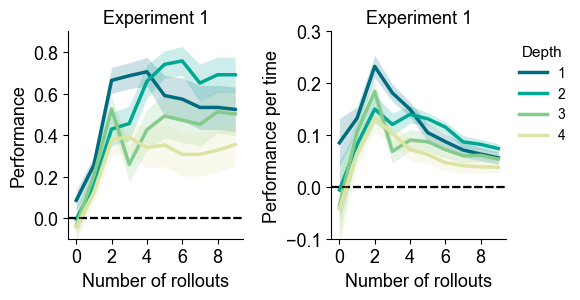

In [15]:
df_smoothed = pd.DataFrame({})

for i in range(num_subj):
    for max_depth in [1, 2, 3, 4]:
        df_depth_subj = df[(df['subj_id'] == i) & (df['max_depths'] == max_depth)]
        
        # df_depth_subj['scores'] = (df_depth_subj['scores'] ) / df_depth_subj['scores'].mean() ###########

        df_depth_subj_smoothed = smooth(df_depth_subj, min_value, max_value, bandwidth)

        df_depth_subj_smoothed['max_depths'] = max_depth

        df_smoothed = pd.concat([df_smoothed, df_depth_subj_smoothed])


plt.figure(figsize = (6, 3.2))
colors = ['#006B7D', '#00A894', '#83CB8B', '#DDE3A0']

for i in range(2):
    df_grouped = df_smoothed.groupby(['rollout_counts', 'max_depths'])['scores'].agg(['mean', 'sem']).reset_index()

    plt.subplot(1, 2, i + 1)

    for k, max_depth in enumerate([1, 2, 3, 4]):
        df_grouped_depth = df_grouped[df_grouped['max_depths'] == max_depth]

        if i == 1:
            df_grouped_depth['mean'] /= (1 + np.array(df_grouped_depth['rollout_counts']) * time_cost_ratio)
            df_grouped_depth['sem'] /= (1 + np.array(df_grouped_depth['rollout_counts']) * time_cost_ratio)

            print(df_grouped_depth)

        plt.plot(df_grouped_depth['rollout_counts'], df_grouped_depth['mean'], color = colors[k], label = max_depth, linewidth = 2.5)
        # plt.axhline(y = 0., color = 'k', linestyle = '--', linewidth = 1)
        plt.fill_between(df_grouped_depth['rollout_counts'], df_grouped_depth['mean'] - df_grouped_depth['sem'], df_grouped_depth['mean'] + df_grouped_depth['sem'], color = colors[k], alpha = 0.2, linewidth = 0)
        plt.axhline(y = 0, linestyle = '--', color = 'k', alpha = 0.8)
        # plt.xlim((0, 9))
        plt.xticks(np.arange(0, 9, 2))
        # plt.ylim((-0.02, 0.08))
        plt.xlabel('Number of rollouts')

        if i == 0:
            plt.ylim((-0.1, 0.9))
            plt.ylabel('Performance')
        elif i == 1:
            plt.ylim((-0.1, 0.3))
            plt.ylabel('Performance per time')
        plt.title('Experiment 1', fontsize = 13)

# plt.legend(bbox_to_anchor = (1.05, 1), title = 'Tree depth', loc = 'upper left', frameon = False, fontsize = 'small')
plt.legend(bbox_to_anchor = (1, 0.7), loc = 'center left', fontsize = 10, frameon = False, title = 'Depth', title_fontsize = '11')
plt.tight_layout()
# plt.show()
plt.savefig('figures/figures_experiment/p_exp1.pdf', bbox_inches = 'tight')